## Optimal Control with Integral Objective

### Original Form

$ min_u \frac{1}{2} \int_0^2 x_1^2(t) dt \\
\mathrm{subject \ to :} \ 
\frac{dx_1}{dt}=u \\ 
x_1(0) = 1 \\
-1 \le u(t) \le 1$

### Equivalent Form for GEKKO with new Variable $x_2$

$\min_u x_2 \ \left(t_f \right) \\
\mathrm{subject \ to :} \
\frac{dx_1}{dt}=u \\
\frac{dx_2}{dt} = \frac{1}{2} x_1^2(t) \\
x_1(0) = 1 \\
x_2(0) = 0 \\
t_f = 2 \\
-1 \le u(t) \le 1$

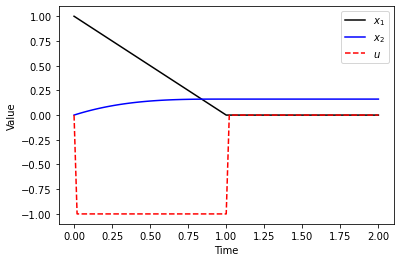

In [3]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

m = GEKKO(remote = False) # initialize gekko
nt = 101
m.time = np.linspace(0,2,nt)

# Variables
x1 = m.Var(value=1)
x2 = m.Var(value=0)
u = m.Var(value=0,lb=-1,ub=1)
p = np.zeros(nt) # mark final time point
p[-1] = 1.0
final = m.Param(value=p) # did this cuz only want the last guy of objective function at tf

# Equations
m.Equation(x1.dt()==u)
m.Equation(x2.dt()==0.5*x1**2)
m.Obj(x2*final) # Objective function
m.options.IMODE = 6 # optimal control mode
m.solve(disp=False) # solve


plt.figure(1) # plot results
plt.plot(m.time,x1.value,'k-',label=r'$x_1$')
plt.plot(m.time,x2.value,'b-',label=r'$x_2$')
plt.plot(m.time,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Optimal Control with Economic Objective
### Original Form

$\max_{u(t)} \ \int_0^{10} \ \left(E - \ \frac{c}{x}\ \right) u \, U_{max} \ dt \\
\mathrm{subject \ to :} \
\frac{dx}{dt}=r \ ,\\ x(t) \ \left(1-\ \frac{x(t)}{k}\ \right)- \ u U_{max} \\
x(0) = 70 \ ,\\
0 \ \le u(t) \ \le 1 \ , \\ 
E=1 \ , \\ c=17.5 \ , \\ r=0.71 \ , \\
k=80.5, \\ U_{max}=20$

### Equivalent Form for GEKKO

$\ \min_{u(t)} -J \ \left(t_f\ \right) \\
\ \mathrm{subject \ to :} 
\ \frac{dx}{dt}=r \, \\ x(t) \ \left(1-\ \frac{x(t)}{k}\ \right)- u \ U_{max}\\
\ \frac{dJ}{dt} = \ \left(E-\ \frac{c}{x}\ \right) u \ U_{max}\\
x(0) = 70\\
J(0) = 0\\
0 \ \le u(t) \ \le 1\\
t_f = 10, \\ E=1, \\ c=17.5 \\
r=0.71, \\ k=80.5, \\ U_{max}=20$

Optimal Profit: 99.243626557


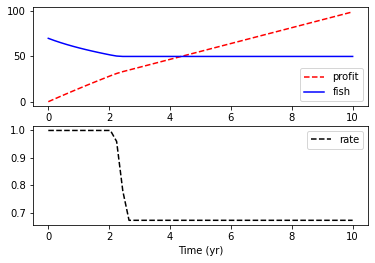

In [2]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

# create GEKKO model
m = GEKKO(remote=False)
# time points
n=50
m.time = np.linspace(0,10,n)
# constants
E,c,r,k,U_max = 1,17.5,0.71,80.5,20
# fishing rate
u = m.MV(value=1,lb=0,ub=1)
u.STATUS = 1
u.DCOST = 0 # No cost of movement, ie no penalty of updating the objective
x = m.Var(value=70, lb=50,ub=100) # fish population
# fish population balance
m.Equation(x.dt() == r*x*(1-x/k)-u*U_max)
J = m.Var(value=0) # objective (profit)
Jf = m.FV() # final objective
Jf.STATUS = 1
m.Connection(Jf,J,pos2='end') # connect to optimise Jf
m.Equation(J.dt() == (E-c/x)*u*U_max)
m.Obj(-Jf) # maximize profit
m.options.IMODE = 6  # optimal control
m.options.NODES = 2  # collocation nodes
m.options.SOLVER = 3 # solver (IPOPT)
m.solve(disp=False) # Solve
print('Optimal Profit: ' + str(Jf.value[0]))
plt.figure(1) # plot results
plt.subplot(2,1,1)
plt.plot(m.time,J.value,'r--',label='profit')
plt.plot(m.time,x.value,'b-',label='fish')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,u.value,'k--',label='rate')
plt.xlabel('Time (yr)')
plt.legend()
plt.show()

## Optimal Control: Minimize Final Time

### Original Form
$\ \min_{u(t)} \  t_f \\
\ \mathrm{subject \ to :} \
\frac{dx_1}{dt}=u \, \\
\frac{dx_2}{dt}=\ \cos\ \left(x_1(t)\ \right) \ , \\
\frac{dx_3}{dt}=\ \sin\ \left(x_1(t)\ \right) \, \\
x(0) = \ \left[\ \pi/2,4,0\ \right] \ , \\ 
x_2\ \left(t_f\ \right)=0 \ , \\
x_3\ \left(t_f\ \right)=0 \ , \\
-2 \ \le u(t) \ \le 2 \ , \\ $

### Equivalent Form for GEKKO

$\ \min_{u(t), t_f} \ t_f \ , \\
\mathrm{subject \ to} \ 
\frac{dx_1}{dt}=t_f \, \\
\frac{dx_2}{dt}=t_f \ \cos \ \left(x_1(t)\ \right) \ , \\
\ \frac{dx_3}{dt}=t_f \ \ \sin\ \left(x_1(t)\ \right), \\
x(0) = \ \left[\ \pi/2,4,0\ \right] \ , \\
x_2\ \left(t_f\ \right)=0 \ , \\
x_3\ \left(t_f\ \right)=0 \ , \\
-2 \ \le u(t) \ \le 2$

In [1]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt  

m = GEKKO(remote=False) # initialize GEKKO
nt = 50
m.time = np.linspace(0,1,nt)
# Variables
x1 = m.Var(value=np.pi/2.0)
x2 = m.Var(value=4.0)
x3 = m.Var(value=0.0)
p = np.zeros(nt) # final time = 1
p[-1] = 1.0
final = m.Param(value=p)
# optimize final time
tf = m.FV(value=1.0,lb=0.1,ub=100.0)
tf.STATUS = 1
# control changes every time period
u = m.MV(value=0,lb=-2,ub=2)
u.STATUS = 1
m.Equation(x1.dt()==u*tf)
m.Equation(x2.dt()==m.cos(x1)*tf)
m.Equation(x3.dt()==m.sin(x1)*tf)
m.Equation(x2*final<=0)
m.Equation(x3*final<=0)
m.Obj(tf)
m.options.IMODE = 6
# m.options.SOLVER = 2
m.solve(disp=False)
print('Final Time: ' + str(tf.value[0]))
tm = np.linspace(0,tf.value[0],nt)
plt.figure(1)
plt.plot(tm,x1.value,'k-',label=r'$x_1$')
plt.plot(tm,x2.value,'b-',label=r'$x_2$')
plt.plot(tm,x3.value,'g--',label=r'$x_3$')
plt.plot(tm,u.value,'r--',label=r'$u$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.show()

Exception: @error: Solution Not Found
